<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/open3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open3D のデモ

## 前準備

### データ読み込み

In [1]:
import pandas as pd

url="https://raw.githubusercontent.com/applejxd/colaboratory/master/data/sample.xyz"
header=["x", "y", "z", "r", "g", "b"]

df=pd.read_csv(url, names=header)
df

x         y         z    r    g    b
0      -1.069480  1.683273 -0.747011   91   85   66
1      -1.061458  1.682688 -0.746155   98   92   78
2      -1.053447  1.682103 -0.745299  100   94   85
3      -1.046957  1.683759 -0.745826   93   89   74
4      -1.041713  1.687300 -0.747512   99   93   72
...          ...       ...       ...  ...  ...  ...
182629  0.772879  2.090749  0.702418  230  225  200
182630  0.783068  2.096087  0.704228  230  225  200
182631  0.795728  2.106619  0.707649  235  229  201
182632  0.798895  2.096860  0.704783  235  229  201
182633  0.820068  2.125105  0.713697  241  234  211

[182634 rows x 6 columns]

### 各種インストール

In [2]:
%%capture
!pip install open3d
import open3d as o3d

In [3]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(df[["x", "y", "z"]].values)
pcd.colors = o3d.utility.Vector3dVector(df[["r", "g", "b"]].values)

In [4]:
import numpy as np
import plotly.graph_objects as go

def draw(geometries):
    graph_obj = []

    for gm in geometries:
        geometry_type = gm.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            pts = np.asarray(gm.points)
            clr = None  #for colors
            if gm.has_colors():
                clr = np.asarray(gm.colors)
            elif gm.has_normals():
                clr = (0.5, 0.5, 0.5) + np.asarray(gm.normals) * 0.5
            else:
                gm.paint_uniform_color((1.0, 0.0, 0.0))
                clr = np.asarray(gm.colors)

            sc = go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers', marker=dict(size=1, color=clr))
            graph_obj.append(sc)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            tri = np.asarray(gm.triangles)
            vert = np.asarray(gm.vertices)
            clr = None
            if gm.has_triangle_normals():
                clr = (0.5, 0.5, 0.5) + np.asarray(gm.triangle_normals) * 0.5
                clr = tuple(map(tuple, clr))
            else:
                clr = (1.0, 0.0, 0.0)
            
            mesh = go.Mesh3d(x=vert[:,0], y=vert[:,1], z=vert[:,2], i=tri[:,0], j=tri[:,1], k=tri[:,2], facecolor=clr, opacity=0.50)
            graph_obj.append(mesh)
        
    fig = go.Figure(
        data=graph_obj,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

o3d.visualization.draw_geometries = draw # replace function

In [5]:
o3d.visualization.draw_geometries([pcd])

## 分析処理

### 画像化

In [72]:
points = np.array(pcd.points)
colors = np.array(pcd.colors)
x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

min_width = 0.05
x_list = np.arange(x_min, x_max+min_width, min_width)
y_list = np.arange(y_min, y_max+min_width, min_width)

print(f"len(x_list)={len(x_list)}")
print(f"len(y_list)={len(y_list)}")

len(x_list)=43
len(y_list)=13


In [74]:
from scipy import stats

matrix = stats.binned_statistic_2d(points[:, 0], points[:, 1], colors.T, 
                                   "mean", bins=[x_list, y_list])
image = matrix.statistic.transpose([1, 2, 0])
image = np.nan_to_num(image)
image[:, :] = image[:, :].astype("int64")
print(image.shape)

(42, 12, 3)


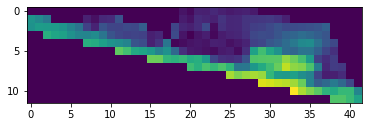

In [75]:
import matplotlib.pyplot as plt

plt.imshow(image[:,:,0].T)

### 点群密度

In [7]:
len(pcd.points)

182634

In [8]:
cl, ind = pcd.remove_radius_outlier(nb_points=700, radius=0.05)
len(ind)

348

In [9]:
point_num_list = np.floor(np.arange(2, 10, 0.25) ** 3).astype("int64")
point_num_list

array([  8,  11,  15,  20,  27,  34,  42,  52,  64,  76,  91, 107, 125,
       144, 166, 190, 216, 244, 274, 307, 343, 381, 421, 465, 512, 561,
       614, 669, 729, 791, 857, 926])

In [10]:
inlier_point_num_list = np.array(
    [len(pcd.remove_radius_outlier(nb_points=num, radius=0.05)[1])
    for num in point_num_list])
inlier_point_num_list

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(point_num_list, inlier_point_num_list)
plt.show()